# Mixer - Parameter Investigation

Author: Felix Hoffmann <br>
Date: 05/05/2024 <br>
Based on: Reduced Basis Methods for Partial Differential Equations - An Introduction

This Tutorial will extend the previous tutorial and will include how to perform simple parameter investigation. 

---

In this chapter we take the function from last chapter and apply a bunch of different choices of test parameters.

---

First we need to setup everything.

In [1]:
### --- Imports --- ###
import numpy as np
import matplotlib.pyplot as plt
import tqdm
from scipy.stats import qmc

import src.helper as helper
import dolfinx
import dolfinx.mesh as xmesh
import dolfinx.fem as xfem
import dolfinx.fem.petsc as xpetsc
import dolfinx.io as xio

import ufl

# Plotting 
import pyvista
import trame
import ipywidgets

### --- Actual Code --- ###
# Setup Code
V, u, v, b, mesh, ds, facet_tag = helper.offlineComputation()
calcPDE = lambda mu: helper.onlineComputation(mu, V, u, v, b, mesh, ds, facet_tag)

Info    : Reading 'src/mesh/mixer.msh'...
Info    : 49 entities
Info    : 1655 nodes
Info    : 3308 elements
Info    : Done reading 'src/mesh/mixer.msh'


---

For ROM we need to choose a suitable basis. In this chapter, we are focusing on the SVD decomposition. For further details you can check the book "Reduced Basis Methods for Partial Differential Equations - An Introduction", Chapter 6, Construction of RB Spaces by SVD-POD.


In short, we are choosing a set of Parameters $\Xi_\mathrm{train}$ and solving the problem for all parameters $\mu \in \Xi_\mathrm{train}$. We then construct the snapshot matrix out of this by setting $A = [u_N(\mu_1) | ... | u_N(\mu_K)]$ with $K = |\Xi_\mathrm{train}|$. The algorithm to calculate the ROM basis requires now to determine the SVD decomposition.<br>
We can investigate the singular values of this SVD decomposition to determine the goodness of this choice of parameter set.

Let's look at an example:

In [2]:
def xi_naiv():
    u0 = calcPDE(np.array([0, 0, 0, 1]))
    u0 = u0.x.array
    AA = np.zeros((u0.shape[0], 3**4))
    i = 0
    
    for mu1 in np.linspace(0, 12, 3):
        for mu2 in np.linspace(0, 12, 3):
            for mu3 in np.linspace(0, 12, 3):
                for mu4 in np.linspace(1, 600, 3):
                    mu = np.array([mu1, mu2, mu3, mu4])
                    uhApprox = calcPDE(mu)
                    AA[:,i] = uhApprox.x.array
                    i += 1
    return AA

def xi_random():
    u0 = calcPDE(np.array([0, 0, 0, 1]))
    u0 = u0.x.array
    AA = np.zeros((u0.shape[0], 3**4))

    for i in range(81):
        mu = [12, 12, 12, 600] * np.random.rand(4)
        uhApprox = calcPDE(mu)
        AA[:,i] = uhApprox.x.array

    return AA

Finished naive Algorithm
Finished random Algorithm


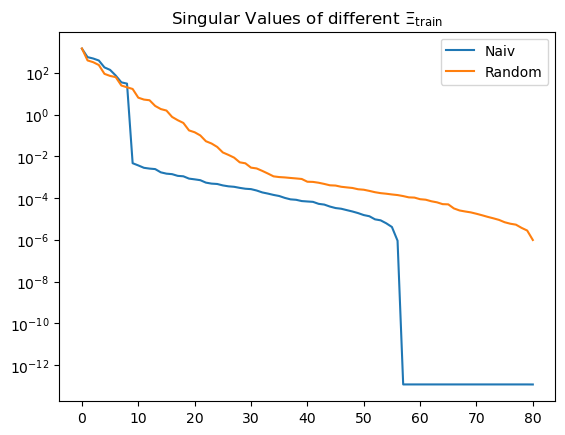

In [3]:
AA1 = xi_naiv()
print("Finished naive Algorithm")
AA2 = xi_random()
print("Finished random Algorithm")

_, SIGMA1, _ = np.linalg.svd(AA1)
_, SIGMA2, _ = np.linalg.svd(AA2)

plt.semilogy(SIGMA1, label="Naiv")
plt.semilogy(SIGMA2, label="Random")
plt.legend()
plt.title(r"Singular Values of different $\Xi_\mathrm{train}$")
plt.plot();

What do we see here? 

We've plotted the singular values of the snapshot matrix of two distinct training sets. One of them is choosen randomly, and the other one by uniform distribution. The Singular Value of the uniform choice drops more rapid than the random choice. 

Which of these two algorithms is now better?<br>
Each singular value responds to one singular vector. These singular vectors span up a vector space. The bigger a singular value is the more important that direction is. Basically what we can say, is that the significant physics in the uniform case happens in the first 8-10 singular values and all of the physics are happening in the first ~57 singular values. <br>
That sounds good, doesn't it? We have a fast decay in singular values! But if we look more closely we see, that this is not a good property. Singular Values are representing information. In the uniform case, we can easily reconstruct the snapshot matrix, because the snapshot matrix is not representing good enough the true underlying physics. Intuitively you can see this if we would have a training sample that represents the parameter set really bad. For example like in the next graphics.

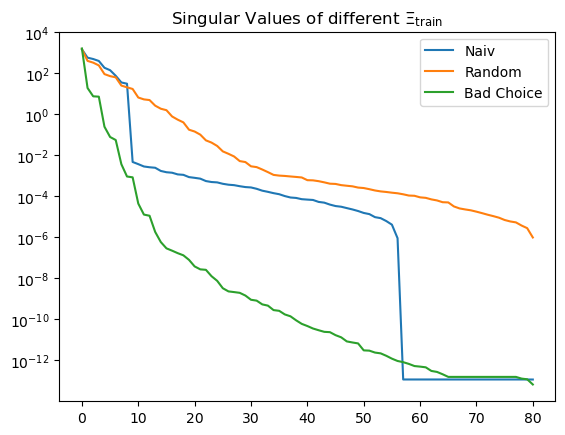

In [4]:
def xi_bad():
    u0 = calcPDE(np.array([0, 0, 0, 1]))
    u0 = u0.x.array
    AA = np.zeros((u0.shape[0], 3**4))

    mu0 = [12, 12, 12, 600] * np.random.rand(4)
    
    for i in range(81): 
        mu = mu0 + [12, 12, 12, 600] * np.random.rand(4) / 50
        uhApprox = calcPDE(mu)
        AA[:,i] = uhApprox.x.array

    return AA


_, SIGMA1, _ = np.linalg.svd(AA1)
_, SIGMA2, _ = np.linalg.svd(AA2)
_, SIGMA3, _ = np.linalg.svd(xi_bad())

plt.semilogy(SIGMA1, label="Naiv")
plt.semilogy(SIGMA2, label="Random")
plt.semilogy(SIGMA3, label="Bad Choice")
plt.legend()
plt.title(r"Singular Values of different $\Xi_\mathrm{train}$")
plt.plot();

We've choosen for the complete sample just parameters really close to $\mu_0$. Our singular values are decaying really fast, because we can describe the snapshotmatrix really good with the vector $u(\mu_0)$. that means, we are looking for a parameterset, which creates a snapshotmatrix, which SVD is decays as slow as possible and has as big singular values as possible. <br>
In the following I'll refer to the singular values also as "information". A matrix has high information if the singular values are decaying slowly, and they are big. 

The question now is how to construct such parametersets yielding high energy.<br>
Therefore we need to represent the complete parameter domain $[0,12]^3 \times [1,600]$ in a suitable style. 

---

The first Idea is to do a uniform distribution in each dimension. We've already implemented this under the name ```xi_naiv```. Let's generalize this approach directly, by doing uniform steps in each dimension, but allowing different number of parameters in different dimensions. 

In [5]:
def uniformTensorial_nxm(NN, uh0Shape):
    NN = np.array(NN).astype(int)
    
    size = NN[0] * NN[1] * NN[2] * NN[3]
    
    mu1 = np.linspace(0, 12, NN[0])
    mu2 = np.linspace(0, 12, NN[1])
    mu3 = np.linspace(0, 12, NN[2])
    mu4 = np.linspace(1, 600, NN[3])
    
    if NN[0] == 1:
        mu1 = np.array([6.])
    if NN[1] == 1:
        mu2 = np.array([6.])
    if NN[2] == 1:
        mu3 = np.array([6.])
    if NN[3] == 1:
        mu4 = np.array([125.])
    
    MU = np.array(np.meshgrid(mu1, mu2, mu3, mu4)).T.reshape(-1, 4)
    
    AA = np.zeros((uh0Shape, size))
    
    for i in tqdm.tqdm(range(size)):
        mu = MU[i]
        uhApprox = calcPDE(mu)
        
        AA[:,i] = uhApprox.x.array

    _, SIGMA, _ = np.linalg.svd(AA)
    
    print(f"Uniform Tensorial with {NN[0]}x{NN[1]}x{NN[2]}x{NN[3]} finished.\n")
    
    return SIGMA

---
The next approach we want to dive in is the random approach. We're choosing our parameters absolutely random. 

In [12]:
def random(NS, uh0Shape):
    AA = np.zeros((uh0Shape, NS))

    for i in tqdm.tqdm(range(NS)):
        mu = np.array([12, 12, 12, 600] * np.random.rand(4))
        uhApprox = calcPDE(mu)
        
        AA[:,i] = uhApprox.x.array

    _, SIGMA, _ = np.linalg.svd(AA)
    
    print("Random Sampling finished.\n")
    
    return SIGMA

---
A variation of the random sampler is the latin hypercube sampler [Wikipedia - Latin hypercube Sampling](https://en.wikipedia.org/wiki/Latin_hypercube_sampling). This provides a more "regular" random pattern. 

In [13]:
def latinHypercube(NS, uh0Shape):
    AA = np.zeros((uh0Shape, NS))
    
    sampler = qmc.LatinHypercube(d=4)
    sample  = sampler.random(n=NS)
    
    for i in tqdm.tqdm(range(NS)):
        sMu = sample[i]
        mu = np.array([12, 12, 12, 600] * sMu)
        uhApprox = calcPDE(mu)
        
        AA[:,i] = uhApprox.x.array
    
    _, SIGMA, _ = np.linalg.svd(AA)
    
    print("Latin Hypercube Sampling finished.\n")
    
    return SIGMA

---
So far we didn't take into account, that our parameter range for $\mu_4$ is far larger than the parameter range of $\mu_1, \mu_2,\mu_3$. In this case, you can either sample more points into that direction, or you use a log-spaced algorithm. In general, it's a good idea for large range parameters to try out log-spaced uniform grids.

In [8]:
def logUniformTensorial_nxlog(NN, uh0Shape):
    NN = np.array(NN).astype(int)
    size = NN[0] * NN[1] * NN[2] * NN[3]
    
    mu1 = np.linspace(0, 12, NN[0])
    mu2 = np.linspace(0, 12, NN[1])
    mu3 = np.linspace(0, 12, NN[2])
    mu4 = np.logspace(np.log(1), np.log(600), NN[3])
    
    MU = np.array(np.meshgrid(mu1, mu2, mu3, mu4)).T.reshape(-1, 4)
   
    AA = np.zeros((uh0Shape, size))
    
    for i in tqdm.tqdm(range(size)):
        mu = MU[i]
        uhApprox = calcPDE(mu).x.array
        
        AA[:,i] = uhApprox

    _, SIGMA, _ = np.linalg.svd(AA)
    
    print(f"Log Uniform Tensorial with {NN[0]}x{NN[1]}x{NN[2]}xLog{NN[3]} finished.\n")
    
    return SIGMA

---
Let's test our theory. We will simply plot the singular values of all the snapshot matrixes defined by the different methods.

In [9]:
masN = 6
divN = 2

uh0 = calcPDE([6, 6, 6, 125]).x.array
uh0Shape = uh0.size

NN1 = np.array([masN, masN, masN, masN]).astype(int)
NN2 = np.array([masN/divN, masN/divN, masN/divN, masN**4 / (masN/divN)**3]).astype(int)

sigma_Uniform1  = uniformTensorial_nxm(NN1, uh0Shape)
sigma_Uniform2  = uniformTensorial_nxm(NN2, uh0Shape)
sigma_Random    = random(masN**4, uh0Shape)
sigma_LHC       = latinHypercube(masN**4, uh0Shape)
sigma_Log       = logUniformTensorial_nxlog(NN2, uh0Shape)

100%|███████████████████████████████████████████████████████████████████████████████| 1296/1296 [12:32<00:00,  1.72it/s]


Uniform Tensorial with 6x6x6x6 finished.



100%|███████████████████████████████████████████████████████████████████████████████| 1296/1296 [12:52<00:00,  1.68it/s]


Uniform Tensorial with 3x3x3x48 finished.



100%|█████████████████████████████████████████████████████████████████████████████| 1296/1296 [1:26:17<00:00,  3.99s/it]


Random Sampling finished.



100%|█████████████████████████████████████████████████████████████████████████████| 1296/1296 [1:19:39<00:00,  3.69s/it]


Latin Hypercube Sampling finished.



100%|███████████████████████████████████████████████████████████████████████████████| 1296/1296 [17:26<00:00,  1.24it/s]


Log Uniform Tensorial with 3x3x3xLog48 finished.



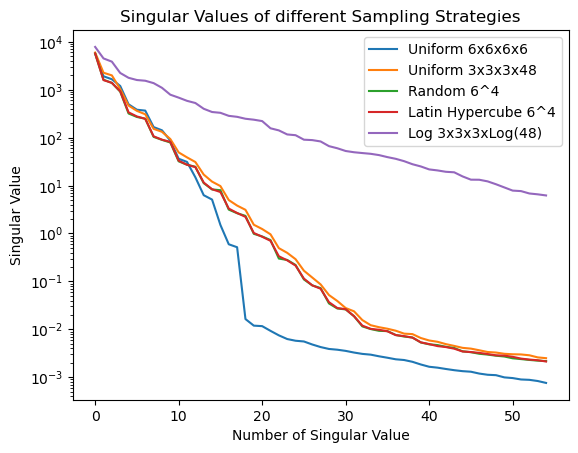

In [10]:
plt.figure()

nMax = 55
plt.semilogy(sigma_Uniform1[:nMax], label=f"Uniform {NN1[0]}x{NN1[1]}x{NN1[2]}x{NN1[3]}")
plt.semilogy(sigma_Uniform2[:nMax], label=f"Uniform {NN2[0].astype(int)}x{NN2[1].astype(int)}x{NN2[2].astype(int)}x{NN2[3].astype(int)}")
plt.semilogy(sigma_Random[:nMax],   label=f"Random {masN}^4")
plt.semilogy(sigma_LHC[:nMax],      label=f"Latin Hypercube {masN}^4")
plt.semilogy(sigma_Log[:nMax],      label=f"Log {NN2[0].astype(int)}x{NN2[1].astype(int)}x{NN2[2].astype(int)}xLog({NN2[3].astype(int)})")

plt.title("Singular Values of different Sampling Strategies")
plt.xlabel("Number of Singular Value")
plt.ylabel("Singular Value")
plt.legend()
plt.show();

So we can see, that the Log Uniform one is the best, meanwhile the Tensorial Uniform the worst is. We will have a closer look on that later. 

---
For technical reasons not all of the simulations have the same number of parameters. Does that make a difference? Intuitively saying, yes! And that's also right. Just imagine comparing 1 Parameter vs. 1mio Parameters. Of course, there's a difference. According to our theorie an increasing number of parameters should yield a higher information gain. Let's check this.

100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:13<00:00,  4.36s/it]


Random Sampling finished.



100%|███████████████████████████████████████████████████████████████████████████████████| 10/10 [01:03<00:00,  6.38s/it]


Random Sampling finished.



100%|███████████████████████████████████████████████████████████████████████████████████| 34/34 [03:19<00:00,  5.87s/it]


Random Sampling finished.



100%|█████████████████████████████████████████████████████████████████████████████████| 117/117 [08:14<00:00,  4.23s/it]


Random Sampling finished.



100%|█████████████████████████████████████████████████████████████████████████████████| 400/400 [32:12<00:00,  4.83s/it]


Random Sampling finished.



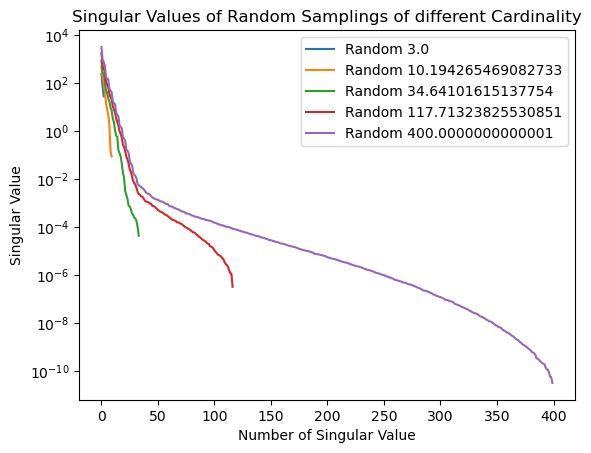

NameError: name 'Ntot' is not defined

<Figure size 640x480 with 0 Axes>

In [15]:
u0 = calcPDE(np.array([0, 0, 0, 1]))
uh0Shape = u0.x.array.size

# Try 1: Random Parameters
plt.figure()
NN = np.logspace(np.log10(3), np.log10(400), 5)
for i, N in enumerate(NN):
    sigma_Random = random(N.astype(int), uh0Shape)
    plt.semilogy(sigma_Random, label=f"Random {N}")
plt.title("Singular Values of Random Samplings of different Cardinality")
plt.xlabel("Number of Singular Value")
plt.ylabel("Singular Value")
plt.legend()
plt.show()


# Try 2: Uniformly Spaced
plt.figure()
NNtot = np.array([[1,1,1,3],
      [2,2,2,6],
      [3,3,3,12],
      [4,4,4,24]])
for i in range(4):
    NN = NNtot[i]
    sigma_Log = logUniformTensorial_nxlog(NN.astype(int), uh0Shape)
    plt.semilogy(sigma_Log, label=f"Log {NN[0].astype(int)}x{NN[1].astype(int)}x{NN[2].astype(int)}x{NN[3].astype(int)}")
plt.title("Singular Values of Log Samplings of different Cardinality")
plt.xlabel("Number of Singular Value")
plt.ylabel("Singular Value")
plt.legend()
plt.show()

We can see, that independent of the sampling algorithm the energy is decreasing with smaller sampling sizes. Nevertheless, the absolute decrease in the energy is quite small for small changes in the number of sampling sizes. Therefore we can neglect the different sampling sizes. 

---

Let's dive into some more investigations.

1. How is the Unifrom Sampling with different sample Sizes performing?

  6%|█████▎                                                                              | 1/16 [00:01<00:24,  1.64s/it]Exception ignored in: <function LinearProblem.__del__ at 0x7ff52652f6a0>
Traceback (most recent call last):
  File "/home/felix/anaconda3/envs/fenicsx/lib/python3.12/site-packages/dolfinx/fem/petsc.py", line 627, in __del__
    self._solver.destroy()
    ^^^^^^^^^^^^
AttributeError: 'LinearProblem' object has no attribute '_solver'
100%|███████████████████████████████████████████████████████████████████████████████████| 16/16 [00:21<00:00,  1.32s/it]


Uniform Tensorial with 2x2x2x2 finished.



100%|█████████████████████████████████████████████████████████████████████████████████| 256/256 [04:09<00:00,  1.03it/s]


Uniform Tensorial with 4x4x4x4 finished.



 40%|███████████████████████████████▋                                               | 1645/4096 [22:02<32:50,  1.24it/s]


KeyboardInterrupt: 

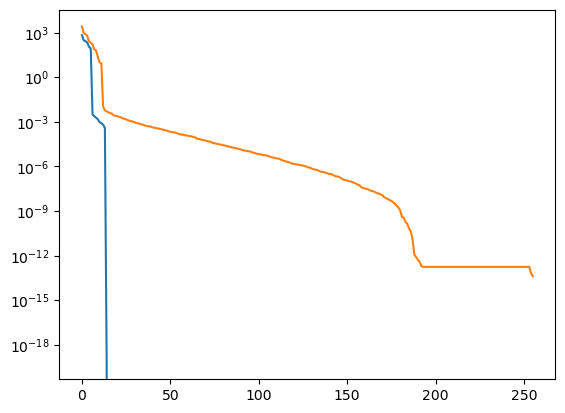

In [17]:
plt.figure()
NN = 3
for i in range(NN):
    NN = np.array([2, 2, 2, 2])**(i+1) 
    sigma_Log = uniformTensorial_nxm(NN.astype(int), uh0Shape)
    plt.semilogy(sigma_Log, label=f"Uniform {2**(i+1)}")
plt.title("Singular Values of Uniform Samplings of different Cardinality")
plt.xlabel("Number of Singular Value")
plt.ylabel("Singular Value")
plt.legend()
plt.show()

2. How is the Tensorial nxm Sampler for different n:m ratios performing?

In [ ]:
plt.figure()
NN = 3
for i in range(NN):
    NN = np.array([3, 3, 3, 2**(i+1)])
    sigma_Log = uniformTensorial_nxm(NN.astype(int), uh0Shape)
    plt.semilogy(sigma_Log, label=f"Uniform 3x{2**(i+1)}")
plt.title("Singular Values of Tensorial nxm Samplings of different n:m ratios")
plt.xlabel("Number of Singular Value")
plt.ylabel("Singular Value")
plt.legend()
plt.show()

3. How is the Log nxm Sampler for different n:m ratios performing?

In [ ]:
plt.figure()
NN = 3
for i in range(NN):
    NN = np.array([3, 3, 3, 2**(i+1)]) 
    sigma_Log = logUniformTensorial_nxlog(NN.astype(int), uh0Shape)
    plt.semilogy(sigma_Log, label=f"Uniform {2**(i+1)}")
plt.title("Singular Values of Log Samplings of different n:m ratios")
plt.xlabel("Number of Singular Value")
plt.ylabel("Singular Value")
plt.legend()
plt.show()

4. How is the problem behaving if we fix $\mu_4$?

In [ ]:
plt.figure()
NN = 4
for i in range(NN):
    NN = np.array([2, 2, 2, 1])**(i+1) 
    sigma_Log = logUniformTensorial_nxlog(NN.astype(int), uh0Shape)
    plt.semilogy(sigma_Log, label=f"Uniform {2**(i+1)} with fix Mu4")
plt.title("Singular Values of Uniform Sampling with fixed Mu4")
plt.xlabel("Number of Singular Value")
plt.ylabel("Singular Value")
plt.legend()
plt.show()